In [1]:
# Installation

# !pip install tensorflow
# !pip install torch      # For PyTorch
# !pip install opencv-python   # For OpenCV
# !pip install numpy      # For NumPy
# !pip install pillow     # For Pillow (PIL)

# !pip install --upgrade numpy
# !pip install numpy==1.22.0  # You can choose a version in the compatible range
# !pip install numpy==1.23.0

# !pip install --upgrade tensorflow
# !pip install --upgrade scipy

In [77]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [78]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Preprocessing and Augmentation


In [79]:
# Data Augmentation (to training data)
    # Data augmentation techniques, such as random rotation, flipping, and zooming, can be applied to the training dataset to increase the diversity of training samples.
    # data augmentation can help improve model generalization by creating variations of training images through random transformations like rotation, shift, shear, and flip.
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values to the range [0, 1] -> Normalization
    rotation_range=20,   # Random rotation up to 20 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,     # Shear transformation
    zoom_range=0.1,      # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    fill_mode='nearest'  # Fill in missing pixels using the nearest value
)


In [80]:
# # preprocess the validation and test datasets, respectively, by rescaling the pixel values to a normalized range. 

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [81]:
# Load Data Using ImageDataGenerator

train_generator = datagen.flow_from_directory(
    '/Users/shanmei/downloads/is460/project/pneunomia/is460-project/dataset/train',  # Path to the training data directory
    target_size=(224, 224),  # Target image size
    batch_size=32,
    class_mode='binary'  # 'binary' for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    '/Users/shanmei/downloads/is460/project/pneunomia/is460-project/dataset/val',  # Path to the validation data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    '/Users/shanmei/downloads/is460/project/pneunomia/is460-project/dataset/test',  # Path to the test data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [82]:
# Check class labels
class_labels = train_generator.class_indices
print(class_labels)

# Check the number of samples in each dataset
num_train_samples = train_generator.samples
num_val_samples = validation_generator.samples
num_test_samples = test_generator.samples

print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of test samples: {num_test_samples}")


{'NORMAL': 0, 'PNEUMONIA': 1}
Number of training samples: 5216
Number of validation samples: 16
Number of test samples: 624


In [83]:
# Check the shapes and other properties of your data
print("X_train shape:", train_generator.image_shape)
print("Number of training samples:", train_generator.samples)

print("X_val shape:", validation_generator.image_shape)
print("Number of validation samples:", validation_generator.samples)


X_train shape: (224, 224, 3)
Number of training samples: 5216
X_val shape: (224, 224, 3)
Number of validation samples: 16


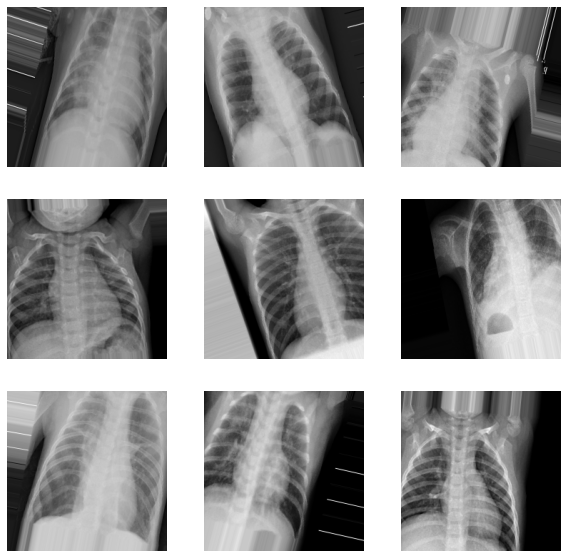

In [84]:
# Visualize augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    augmented_image, _ = train_generator.next()
    plt.imshow(augmented_image[0])
    plt.axis('off')
plt.show()


# Define the CNN Model

Sequential: This is the base Keras model that allows you to build a neural network by adding layers one after the other in a sequential manner. Each layer represents a specific operation, such as convolution, pooling, or dense (fully connected) layers.

Conv2D: This layer represents a 2D convolution operation. It is used to extract features from the input image. In your code, you have three Conv2D layers with 32, 64, and 128 filters, respectively. The (3, 3) argument specifies the size of the convolutional kernel (a 3x3 grid), and activation='relu' indicates the Rectified Linear Unit activation function is used.

MaxPooling2D: This layer performs max-pooling, which downsamples the feature maps generated by the convolutional layers. It helps reduce the spatial dimensions and computational complexity of the network. The (2, 2) argument indicates a 2x2 pooling window.

Flatten: This layer is used to flatten the output from the previous layers into a 1D vector. This is typically done before feeding the data into fully connected layers.

Dense: These are fully connected layers, also known as dense layers. In your code, you have two dense layers with 128 units each. The activation function used is 'relu' for the first dense layer and 'sigmoid' for the second one. The final dense layer with one unit and a sigmoid activation function is often used for binary classification tasks, where the output represents the probability of belonging to a specific class (in this case, the probability of a binary class).

Dropout: This layer applies dropout regularization to the previous layer. It randomly drops a fraction of the input units during training, which helps prevent overfitting by reducing the reliance on specific neurons.

In [85]:
# Define the CNN Model

# Define dropout rate (e.g., 0.2)
dropout_rate = 0.2  # Adjust this value

# L2 weight regularization
from tensorflow.keras.regularizers import l2
# Define regularization strength (e.g., 0.001)
l2_strength = 0.01  # Adjust this value

# Add L2 weight regularization to layers that you want to regularize
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength), input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_strength)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(l2_strength)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])
# Adjust the number of filters, kernel sizes, activation functions, and other hyperparameters based on your project requirements.
# The last dense layer has a single neuron with a sigmoid activation function, which is suitable for binary classification. If you have more than two classes, use a softmax activation function and adjust the number of neurons accordingly.

In [86]:
# Compile the model
from tensorflow.keras.optimizers import Adam

# Define hyperparameters
learning_rate = 0.001  # Adjust this value
batch_size = 32       # Adjust this value

# Create an optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the updated optimizer and batch size
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [87]:
# Summary of the model
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 26, 26, 128)      

# Train the CNN Model

Epoch => Specify the number of iterations over the entire dataset. During each epoch, the entire training dataset is processed once by the model.

loss => training loss for the current epoch. It represents how well the model is fitting the training data.

accuracy => This is the training accuracy for the current epoch. It represents the proportion of correctly predicted samples in the training data.

val_loss => This is the validation loss for the current epoch. It measures how well the model is performing on a separate validation dataset that it hasn't seen during training.

val_accuracy => This is the validation accuracy for the current epoch. It represents the proportion of correctly predicted samples in the validation dataset.

In [88]:
# Early stopping is a technique used during the training of machine learning models to prevent overfitting. It involves monitoring a specified validation metric (e.g., validation loss) during training and stopping the training process when the metric stops improving or starts degrading.

from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)


# Example usage during model training
# Train the model with the updated hyperparameters
history = model.fit(
    train_generator,
    epochs=10,
    batch_size = batch_size,
    validation_data=  validation_generator,
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)


Epoch 1/10
163/163 [==============================] - 320s 2s/step - loss: 1.0898 - accuracy: 0.7527 - val_loss: 0.9850 - val_accuracy: 0.5625
Epoch 2/10
163/163 [==============================] - 314s 2s/step - loss: 0.6385 - accuracy: 0.7655 - val_loss: 0.9970 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 324s 2s/step - loss: 0.5143 - accuracy: 0.8301 - val_loss: 0.8481 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 339s 2s/step - loss: 0.4654 - accuracy: 0.8476 - val_loss: 0.8349 - val_accuracy: 0.6250
Epoch 5/10
163/163 [==============================] - 320s 2s/step - loss: 0.4336 - accuracy: 0.8505 - val_loss: 1.0167 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 323s 2s/step - loss: 0.4130 - accuracy: 0.8583 - val_loss: 0.8349 - val_accuracy: 0.6250
Epoch 7/10
163/163 [==============================] - 354s 2s/step - loss: 0.3906 - accuracy: 0.8760 - val_loss: 0.6546 - val_accuracy: 0.6875

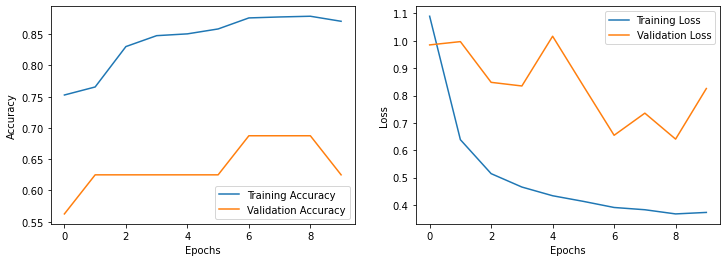

In [89]:
# Visualize training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Evaluating the model on train set

163/163 [==============================] - 209s 1s/step


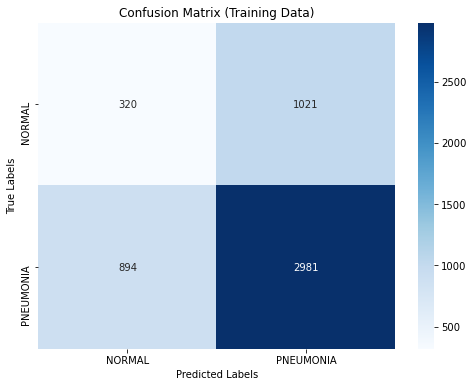

Accuracy: 0.6329
Precision: 0.7449
Recall: 0.7693
F1-Score: 0.7569


In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions on the training data
y_pred_probabilities = model.predict(train_generator)

# Convert probabilities to binary classes (assuming threshold of 0.5)
y_pred_binary = (y_pred_probabilities > 0.5).astype(int)

# Get the true labels for the training data
y_true = train_generator.classes

# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred_binary)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Training Data)')
plt.show()

# Calculate metrics
TP = confusion[1][1]
FP = confusion[0][1]
TN = confusion[0][0]
FN = confusion[1][0]

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision
precision = TP / (TP + FP)

# Recall (Sensitivity)
recall = TP / (TP + FN)

# F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# Evaluating model on test set


In [92]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.2f}")

20/20 [==============================] - 16s 752ms/step - loss: 0.5057 - accuracy: 0.8029
Test accuracy: 0.80


# To evaluate your model using a confusion matrix with a test generator

True Positives (TP): These are cases where your model correctly predicted that the condition (pneumonia) is present. In your case, the model correctly predicted pneumonia in 362 images.

False Positives (FP): These are cases where your model incorrectly predicted that the condition is present when it's not. In your case, the model made 40 false positive predictions, indicating that it predicted pneumonia when it was not actually present.

True Negatives (TN): These are cases where your model correctly predicted that the condition is not present (normal). In your case, the model correctly predicted normal in 194 images.

False Negatives (FN): These are cases where your model incorrectly predicted that the condition is not present when it is. In your case, the model made 28 false negative predictions, indicating that it failed to detect pneumonia in cases where it was actually present.


In [93]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a custom data generator for test data
test_data_generator = ImageDataGenerator(rescale=1.0/255.0)  # Adjust rescaling as needed

# Load and preprocess test data using the generator
test_generator = test_data_generator.flow_from_directory(
    '/Users/shanmei/downloads/is460/project/pneunomia/is460-project/dataset/test',  # Path to the test data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,  # Do not shuffle test data
)

# Generate predictions for the test dataset
y_pred = model.predict(test_generator)

# Convert predicted probabilities to class labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype(int)

# Get true labels from the test generator
y_true = test_generator.classes

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:")
print(confusion)

# A    Predicted
# c     +    -
# t  + [TN, FP]
# u
# a  - [FN, TP]
# l

Found 624 images belonging to 2 classes.
20/20 [==============================] - 17s 786ms/step
Confusion Matrix:
[[139  95]
 [ 28 362]]


In [94]:
# Assuming you have a confusion matrix in the form of a 2x2 NumPy array
# confusion_matrix = [[TN, FP],
#                     [FN, TP]]

# Calculate metrics
TP = confusion[1][1]
FP = confusion[0][1]
TN = confusion[0][0]
FN = confusion[1][0]

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision
precision = TP / (TP + FP)

# Recall (Sensitivity)
recall = TP / (TP + FN)

# F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Accuracy: 0.8029
Precision: 0.7921
Recall: 0.9282
F1-Score: 0.8548


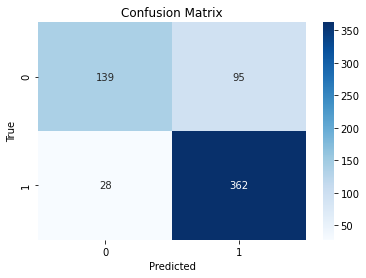

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred_labels)

# Create a heatmap
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


20/20 [==============================] - 14s 646ms/step


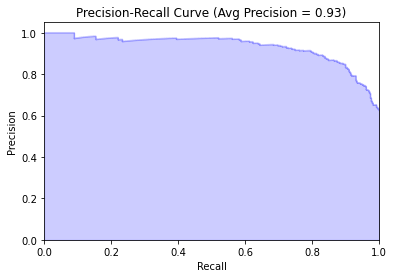

Confusion Matrix:
[[139  95]
 [ 28 362]]
Accuracy: 0.80
Precision (Class 0 - Negative): 0.62
Precision (Class 1 - Positive): 0.63
Recall (Class 0 - Negative): 1.00
Recall (Class 1 - Positive): 1.00
F1 Score: 0.85


In [96]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

# Get the true labels for your test data
y_true = test_generator.classes

# Obtain predictions from your model
y_pred_probabilities = model.predict(test_generator)

# Assuming y_pred_probabilities is a 1D array where y_pred_probabilities represents probabilities of the positive class
# In binary classification, you can also convert probabilities to binary predictions
y_pred_binary = (y_pred_probabilities > 0.5).astype(int)

# Calculate confusion matrix
confusion = confusion_matrix(y_true, y_pred_binary)


# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_true, y_pred_probabilities)
avg_precision = average_precision_score(y_true, y_pred_probabilities)

# Plot precision-recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.show()

# Print evaluation metrics for both classes
print(f'Confusion Matrix:\n{confusion}')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision (Class 0 - Negative): {precision[0]:.2f}')
print(f'Precision (Class 1 - Positive): {precision[1]:.2f}')
print(f'Recall (Class 0 - Negative): {recall[0]:.2f}')
print(f'Recall (Class 1 - Positive): {recall[1]:.2f}')
print(f'F1 Score: {f1:.2f}')  # There's only one F1 Score in binary classification


In [98]:
# Save the entire model to a HDF5 file
model.save('my_CNN_model2.h1')


# Later, when you want to load the model, you can use the load_model function from Keras:
from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model('my_CNNmodel.h1')


INFO:tensorflow:Assets written to: my_CNN_model2.h1/assets


INFO:tensorflow:Assets written to: my_CNN_model2.h1/assets
